In [1]:
import numpy as np
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

dateparse = lambda dates: [datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in dates]
    
dataset = pd.read_csv("city_hour.csv", index_col=0, parse_dates=['Datetime'], date_parser=dateparse)

dataset.drop('AQI_Bucket', axis=1, inplace=True)
dataset.fillna(method='bfill', inplace=True)

col_names = dataset.columns

dataset = dataset.loc['Delhi']
dataset.to_csv('delhiHourData.csv')

df = pd.read_csv("delhiHourData.csv", header=0, index_col=1)
del df['City']
df = df['SO2']
df.head()



Datetime
2015-01-01 01:00:00    3.41
2015-01-01 02:00:00    3.88
2015-01-01 03:00:00    2.83
2015-01-01 04:00:00    4.33
2015-01-01 05:00:00    6.17
Name: SO2, dtype: float64

In [2]:
df.to_frame()

,SO2
Datetime,
2015-01-01 01:00:00,3.41
2015-01-01 02:00:00,3.88
2015-01-01 03:00:00,2.83
2015-01-01 04:00:00,4.33
2015-01-01 05:00:00,6.17
...,...
2020-06-30 20:00:00,10.64
2020-06-30 21:00:00,10.59
2020-06-30 22:00:00,10.20


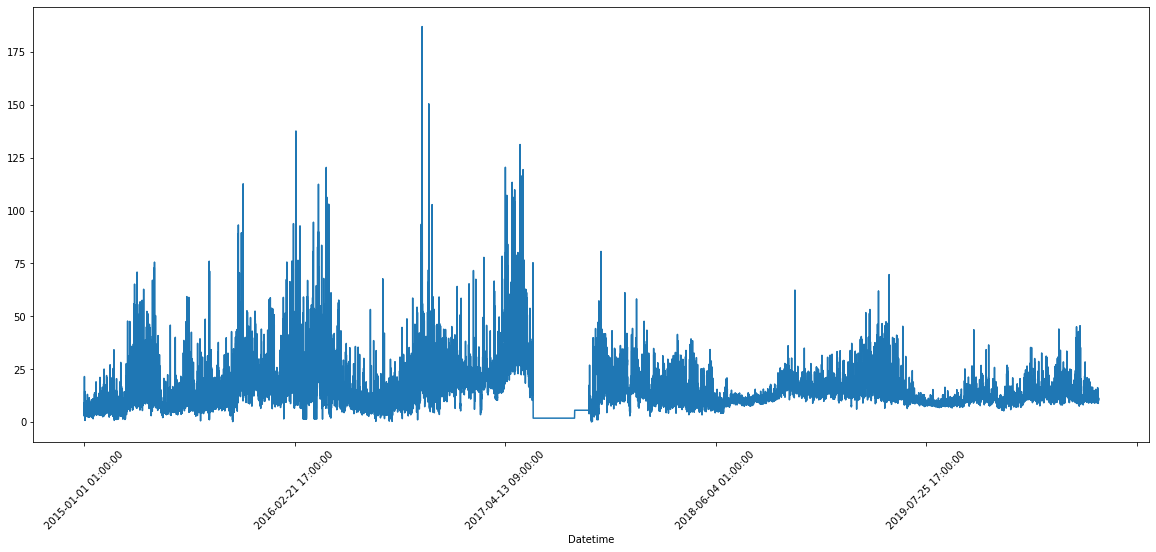

In [3]:
df.plot(x='Datetime',y='SO2',figsize=(20,8))
plt.xticks(rotation=45)

plt.show()

In [4]:
import math

dataset  = df.values
dataset = dataset.reshape(-1, 1)
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

38554

In [5]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0,1))
scaled_data = sc.fit_transform(dataset)
scaled_data

array([[0.01812543],
       [0.0206384 ],
       [0.01502433],
       ...,
       [0.05442977],
       [0.05860022],
       [0.05950917]])

In [6]:
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []
num = 24

for i in range(num, len(train_data)):
    x_train.append(train_data[i-num:i , 0])
    y_train.append(train_data[i , 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape

(38530, 24, 1)

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM
model = Sequential()

model.add(LSTM(units = 50, return_sequences = False, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(Dense(units = 25))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')   

In [8]:
model.fit(x_train, y_train, batch_size=30, epochs=10)

Epoch 1/10
1285/1285 [==============================] - 16s 10ms/step - loss: 0.0010
Epoch 2/10
1285/1285 [==============================] - 13s 10ms/step - loss: 8.5728e-04
Epoch 3/10
1285/1285 [==============================] - 13s 10ms/step - loss: 8.2667e-04
Epoch 4/10
1285/1285 [==============================] - 12s 9ms/step - loss: 8.2066e-04
Epoch 5/10
1285/1285 [==============================] - 12s 9ms/step - loss: 8.3011e-04
Epoch 6/10
1285/1285 [==============================] - 10s 8ms/step - loss: 8.1944e-04
Epoch 7/10
1285/1285 [==============================] - 11s 8ms/step - loss: 8.1006e-04
Epoch 8/10
1285/1285 [==============================] - 12s 10ms/step - loss: 8.0503e-04
Epoch 9/10
1285/1285 [==============================] - 12s 9ms/step - loss: 8.0040e-04
Epoch 10/10
1285/1285 [==============================] - 13s 10ms/step - loss: 8.0125e-04


In [9]:
test_data = scaled_data[training_data_len-24: , :]
x_test = []
y_test = dataset[training_data_len:,:]

for i in range(num, len(test_data)):
      x_test.append(test_data[i-num:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [10]:
predictions = model.predict(x_test)
predictions = sc.inverse_transform(predictions)


302/302 [==============================] - 2s 4ms/step


In [11]:
#RMSE

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
rmse

2.6073139207726275

In [12]:
#MAE

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, predictions)
mae

2.3130405446666233

In [13]:
#R2

from sklearn.metrics import r2_score
r2 = r2_score(y_test, predictions)
r2

0.6684582374153505

In [20]:
train = df[:training_data_len]
valid = df[training_data_len:]
#df = df.to_frame()
#valid = valid.to_frame()
valid["Predictions"] = predictions
df.columns = df.columns.str.replace(' ', '')


C:\Users\Aadi\AppData\Local\Temp\ipykernel_9220\1665155572.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Predictions"] = predictions


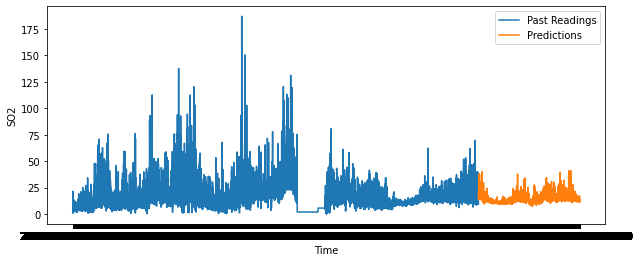

In [22]:
plt.figure(figsize=(10,4))
plt.xlabel("Time", fontsize = 10)
plt.ylabel("SO2",fontsize=10)
plt.plot(train["SO2"])
plt.plot(valid["Predictions"])
plt.legend(["Past Readings","Predictions"])
plt.show()